In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from metal.contrib.slicing.synthetics.geometric_synthetics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
l2=0
lr=0.01
n_epochs=80

In [3]:
RUN_NAME = "foo8"
NUM_SLICES = 5
SEED = 123
K = 2
M = 20
N = 5000
unipolar = False

At least one slice was clobbered. Trying again.


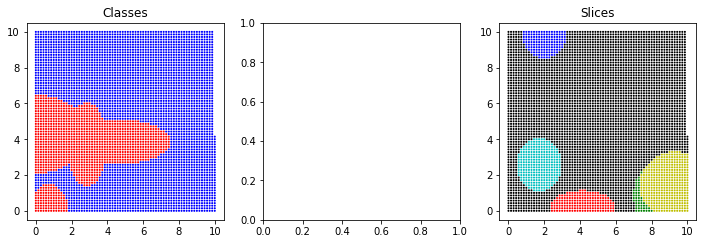

In [4]:
L, X, Y, Z = generate_dataset(
    K, M, N, 
    unipolar=unipolar,
    L_kwargs=({'max_r': 7} if unipolar else {'max_r': 5}),
    Z_kwargs={'num_slices': NUM_SLICES},
)

### Analyze Data

In [5]:
from scipy.sparse import csr_matrix
import torch

L = csr_matrix(L)
X = torch.Tensor(X)

In [6]:
from metal.utils import split_data

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, 
                            splits=[0.5, 0.25, 0.25], 
                            shuffle=True, seed=123)

In [7]:
from metal.analysis import lf_summary

df = lf_summary(Ls[1], Ys[1])
df

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",0.0968,0.0968,0.0752,83,38,0.685950
1,"[1, 2]",0.0624,0.0592,0.0448,48,30,0.615385
2,"[1, 2]",0.3328,0.2784,0.1824,297,119,0.713942
3,"[1, 2]",0.1320,0.1272,0.0840,132,33,0.800000
4,"[1, 2]",0.1288,0.1264,0.0968,115,46,0.714286
5,"[1, 2]",0.1168,0.1168,0.0888,88,58,0.602740
6,"[1, 2]",0.4144,0.3856,0.2768,342,176,0.660232
7,"[1, 2]",0.0656,0.0640,0.0472,61,21,0.743902
8,"[1, 2]",0.1416,0.1336,0.1016,135,42,0.762712
9,"[1, 2]",0.1064,0.0984,0.0656,79,54,0.593985


In [8]:
df.mean()

Coverage       0.128840
Overlaps       0.120680
Conflicts      0.085960
Correct      110.150000
Incorrect     50.900000
Emp. Acc.      0.685091
dtype: float64

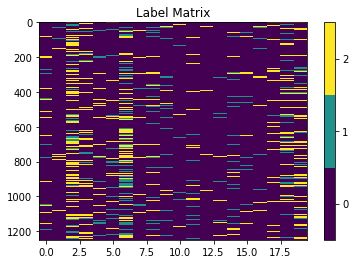

In [9]:
from metal.contrib.visualization.analysis import view_label_matrix

view_label_matrix(Ls[1])

In [10]:
# num_votes = Ls[0].sum(axis=1)
# plt.hist(num_votes)

In [11]:
# np.save('synthetic_data.npy', (L, Y))

### Add pepper

In [12]:
# from collections import Counter

# Ls[0]

In [13]:
# df = lf_summary(Ls[1], Ys[1])
# df.mean()

In [14]:
# view_label_matrix(L)

In [15]:
# from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
# from metal.contrib.slicing.utils import add_pepper

# for pepper in [0, 0.05, 0.1, 0.2, 0.5]:
#     print(pepper)
#     L_temp = add_pepper(Ls[0], pepper)

#     label_model = SnorkelLabelModel()
#     label_model.train_model(L_temp)

#     label_model.score((Ls[1], Ys[1]))

# Learn

In [16]:
# L, Y = np.load('synthetic_data.npy')

### Snorkel LabelModel

In [17]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

In [18]:
from metal.metrics import accuracy_score

Y_train_ps = label_model.predict_proba(Ls[0])
Y_train_p = label_model.predict(Ls[0])

Y_dev_ps = label_model.predict_proba(Ls[0])
Y_dev_p = label_model.predict(Ls[1])
accuracy_score(Ys[1], Y_dev_p)

0.7056

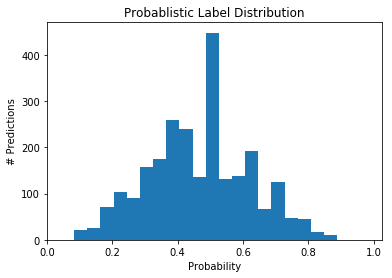

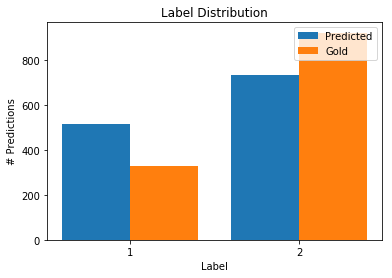

In [19]:
from metal.contrib.visualization.analysis import (
    plot_predictions_histogram, 
    plot_probabilities_histogram,
)
    
plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")
plot_predictions_histogram(Y_dev_p, Ys[1], title="Label Distribution")

## Compare Baselines

In [20]:
# from torch.utils.data import DataLoader
# from metal.utils import SlicingDataset
# from metal.contrib.slicing.utils import evaluate_slicing

# eval_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]))

# results = {}
# for model_name, model in trained_models.items():
#     scores = evaluate_slicing(model, eval_loader, verbose=False)
#     results[model_name] = {k:v['accuracy'] for k,v in scores.items()}
    
# import pandas as pd
# pd.DataFrame.from_dict(results)

### EndModel

In [21]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

train_loader = DataLoader(
    SlicingDataset(Xs[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

In [22]:
import torch
from metal.contrib.logging.tensorboard import TensorBoardWriter
from metal.end_model import EndModel

logger = TensorBoardWriter(log_dir='checkpoints', run_dir='dp', run_name=RUN_NAME)

layer_out_dims = [2,10,10,2]
end_model = EndModel(layer_out_dims, seed=SEED)

end_model.train_model(
    train_loader, 
    dev_data=(Xs[1], Ys[1]), 
    l2=l2, 
    lr=lr,
    n_epochs=n_epochs, 
    print_every=10, 
    log_writer=logger,
    validation_metric='accuracy', 
    disable_prog_bar=True
)
end_model.score((Xs[1], Ys[1]))


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Saving model at iteration 0 with best score 0.738
[E:0]	Train Loss: 0.694	Dev accuracy: 0.738
Saving model at iteration 1 with best score 0.751
Saving model at iteration 2 with best score 0.815
Saving model at iteration 4 with best score 0.823
Saving model at iteration 5 with best score 0.846
Saving model at iteration 8 with best score 0.881
Saving model at iteration 10 with best score 0.904
[E:10]	Train Loss: 0.685	Dev accuracy: 0.904
Saving model at iteration 12 with best score 0.918
[E:20]	Train Loss: 0.684	Dev accuracy: 0.899
Saving model at iteration 21 with best score 0.922
Saving model at iteration 24 with best score 0.924
[E:30]	Train Loss: 0.683	Dev accuracy: 0.916
[

0.9272

## Slice Family

In [23]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

Ls_tensors = [torch.Tensor(np.asarray(L.todense())) for L in Ls]

train_loader = DataLoader(
    SlicingDataset(Xs[0], Ls_tensors[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

dev_loader = DataLoader(
    SlicingDataset(Xs[1], Ys[1]),
    batch_size=256,
)

### SliceModel

In [24]:
# import torch.nn as nn
# from metal.contrib.slicing.online_dp import SliceDPModel, MLPModule
# from metal.contrib.logging.tensorboard import TensorBoardWriter

# logger = TensorBoardWriter(log_dir='checkpoints', run_dir='slice_orig')


# n, m = Ls[0].shape
# input_dim = Xs[0].shape[1]

# input_module = MLPModule(input_dim, 10, [10], bias=True)
# slice_orig = SliceDPModel(input_module, r=10, m=m, reweight=False, slice_weight=0.1, 
#                            verbose=False)
# slice_orig.train_model(
#     train_loader,
#     dev_data=dev_loader,
#     l2=0.0, 
#     n_epochs=40,
#     print_every=5, 
#     validation_metric='accuracy',
#     log_writer=logger,
#     verbose=True, 
#     use_cuda=False,
#     disable_prog_bar=True,
# )

### SliceHatModel

In [25]:
from metal.contrib.slicing.online_dp import SliceHatModel
from metal.contrib.logging.tensorboard import TensorBoardWriter

logger = TensorBoardWriter(log_dir='checkpoints', run_dir='slice_hat', run_name=RUN_NAME)

base_model = EndModel(layer_out_dims)
slice_hat = SliceHatModel(end_model, M, slice_weight=0, reweight=False, seed=SEED)

slice_hat.train_model(
    train_loader,
    dev_data=dev_loader,
    l2=l2, 
    lr=lr,
    n_epochs=n_epochs, 
    print_every=10, 
    validation_metric='accuracy',
    log_writer=logger,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Resetting base model parameters
SliceHatModel(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (Y_head_off): Linear(in_features=10, out_features=2, bias=True)
  (Y_criteria): SoftCrossEntropyLoss()
)

Saving model at iteration 0 with best score 0.738
[E:0]	Train Loss: 0.694	Dev accuracy: 0.738
Saving model at iteration 1 with best score 0.751
Saving model at iteration 2 with best score 0.815
Saving model at iteration 4 with best score 0.823
Saving model at iter

### SliceOnlineModel

In [26]:
# from metal.contrib.slicing.online_dp import SliceOnlineModel
# from metal.contrib.logging.tensorboard import TensorBoardWriter

# logger = TensorBoardWriter(log_dir='checkpoints', run_dir='slice_online', run_name=RUN_NAME)

# slice_online = SliceOnlineModel(end_model, M, L_head_weight=0.1, Y_head_weight=0.1)

# slice_online.train_model(
#     train_loader,
#     dev_data=dev_loader,
#     l2=l2, 
#     lr=lr,
#     n_epochs=n_epochs, 
#     print_every=10, 
#     validation_metric='accuracy',
#     log_writer=logger,
#     verbose=True, 
#     use_cuda=False,
#     disable_prog_bar=True,
# )

## Evaluation

In [27]:
from collections import defaultdict

from metal.contrib.slicing.experiment_utils import eval_model

from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

eval_loader = DataLoader(SlicingDataset(Xs[2], Ys[2], Zs[2]))

history = defaultdict(list)
history['dp'].append(eval_model(end_model, eval_loader, verbose=False))
# history['slice_orig'].append(eval_model(slice_orig, eval_loader, verbose=False))
history['slice_hat'].append(eval_model(slice_hat, eval_loader, verbose=False))
# history['slice_online'].append(eval_model(slice_online, eval_loader, verbose=False))


SUMMARY (accuracies):
All: 0.9272
Slice 0: 0.9314516129032258
Slice 1: 1.0
Slice 2: 1.0
Slice 3: 1.0
Slice 4: 1.0
Slice 5: 0.6666666666666666

SUMMARY (accuracies):
All: 0.9272
Slice 0: 0.9314516129032258
Slice 1: 1.0
Slice 2: 1.0
Slice 3: 1.0
Slice 4: 1.0
Slice 5: 0.6666666666666666


In [28]:
from metal.contrib.slicing.experiment_utils import parse_history

print(f"Average (n=1):")
df = parse_history(history, NUM_SLICES)
df

Average (n=1):


,dp,slice_hat
all,0.927200,0.927200
slice_1,1.000000,1.000000
slice_2,1.000000,1.000000
slice_3,1.000000,1.000000
slice_4,1.000000,1.000000
slice_5,0.666667,0.666667
slice_avg,0.933333,0.933333


In [29]:
# L_pred = np.round(slicer.predict_L_proba(Xs[1]).numpy())
# L_pred[L_pred == 0] = 2
# accuracy_score(Ls[1].reshape(-1,1), L_pred.reshape(-1,1), ignore_in_gold=[0])

In [30]:
# ((Ls[1] == L_pred).sum(axis=0)/(Ls[1] != 0).sum(axis=0)).mean()

In [31]:
# from metal.label_model import LabelModel
# label_model = LabelModel()
# label_model.train_model(Ls[0], n_epochs=500, print_every=20)
# label_model.score((Ls[1], Ys[1]))

# Y_train = label_model.predict_proba(Ls[0])
# Ys[0] = Y_train